In [44]:
import numpy as np

import ngsolve 
from ngsolve.webgui import Draw
import netgen.geom2d

import math

### The complex Ginzburg-Landau model on a different mesh in ngsolve

In [10]:
# let's make some kind of domain
#https://docu.ngsolve.org/latest/netgen_tutorials/define_2d_geometries.html
#https://docu.ngsolve.org/latest/i-tutorials/unit-4.1.2-csg2d/csg2d.html
#geo = netgen.geom2d.SplineGeometry()
geo = netgen.geom2d.CSG2d()

rect = netgen.geom2d.Solid2d( [\
    (-1,-0.5) ,netgen.geom2d.EdgeInfo(bc="rect-bot"),
    (1,-0.5),netgen.geom2d.EdgeInfo(bc="rect-right"),
    (1,0.5), netgen.geom2d.EdgeInfo(bc="rect-top"),
    (-1,0.5), netgen.geom2d.EdgeInfo(bc="rect-left") ] )

fac = 20
rect.Scale(fac)   # .Move((2,0))  netgen.geom2d import EdgeInfo

square = netgen.geom2d.Solid2d( [
    (-1,-1),netgen.geom2d.EdgeInfo(bc="sq-bot"),
    (1,-1),netgen.geom2d.EdgeInfo(bc="sq-right"),
    (1,1),netgen.geom2d.EdgeInfo(bc="sq-top"),
    (-1,1),  netgen.geom2d.EdgeInfo(bc="sq-left"),  \
    ])
square.Scale(10)
square.Rotate(30, center=(0.0,0.0))
square.Move((-70,0))

#circle1 = netgen.geom2d.Circle( center=(0,0), radius=1.0,  bc="outer" )
facc = 30
circle1 = netgen.geom2d.Circle( center=(0,0), radius=1,  bc="circ1" )
circle1.Scale(facc).Move((35,0))
circle2 = netgen.geom2d.Circle( center=(0,0), radius=1,  bc="circ2" )
circle2.Scale(facc).Move((-35,0))
#circle3 = netgen.geom2d.Circle( center=(0,0), radius=1,  bc="inner" )
#circle3.Scale(facc).Move((-0,0))
geo.Add(rect+circle1+circle2+ square)

#geo.Add(-circle2)

maxhval = 2.   # sets size of elements 
mesh = ngsolve.Mesh(geo.GenerateMesh (maxh=maxhval))

Draw(mesh)
print(mesh.GetBoundaries())

#mtemp = geo.GenerateMesh (maxh=maxhval); Draw(mtemp) 
# lets you look at the mesh without making it into a full mesh that is suitable for FEM

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

('circ2', 'circ2', 'rect-top', 'circ1', 'circ1', 'circ1', 'circ1', 'rect-bot', 'circ2', 'circ2', 'sq-bot', 'sq-left', 'sq-top', 'sq-right')


In [11]:
# creating a complex element from two real fields
korder = 2
Q = ngsolve.H1(mesh, order=korder,dirichlet="sq-bot|sq-left|sq-top") 
#fes = ngsolve.H1(mesh, order=3, complex=True)  # We need a complex element!
fes = Q*Q
(ux,uy), (vx,vy) = fes.TnT() # trial and test functions!
#gfu = ngsolve.GridFunction(fes) # to hold the solution 


In [3]:
# create initial conditions!

# first get min and max x,y coordinates of mesh 
def get_range(mesh):
    xv = np.zeros(mesh.nv)
    yv = np.zeros(mesh.nv)
    k=0
    for v in mesh.vertices:
        xv[k] = v.point[0]
        yv[k] = v.point[1]
        k+= 1
    xxmax = np.max(xv)
    xxmin = np.min(xv)
    yymax = np.max(yv)
    yymin = np.min(yv)
    return xxmin,xxmax,yymin,yymax 

xxmin,xxmax,yymin,yymax = get_range(mesh)  # relevant for generating seeds when generating initial conditions 

# create initial condition 
# arguments:
#   gfu: grid function on finite element space for loading with initial conditions
#   nseeds: number of real 1 seeds, 
#   sig:  a random dispersion for choosing random initial conditions 
# returns: 
#   nothing, but gfu.components are set 
# globals:  
#   xxmin,xxmax,yymin,yymax to constrain random initial positions for seeds 
#   maxhval for setting width of gaussian seeds, this is a width    
def gen_init(gfu,nseeds,sig):

    A_r = gfu.components[0]
    A_i = gfu.components[1]
    r1  = A_r.vec.CreateVector()  # create a vector, consistent with gfu
    r1.SetRandom(); # fill with random complex numbers 
    r1 = sig*r1  # scale by sig
    r2  = A_i.vec.CreateVector()  # create a vector, consistent with gfu
    r2.SetRandom(); # fill with random complex numbers 
    r2 = sig*r2  # scale by sig
    ccf = 0.0  # will be a coefficient function 

    # seed with some 1 values 
    for k in range(nseeds):
        x_p = np.random.uniform(xxmin,xxmax)  # random position
        y_p = np.random.uniform(yymin,yymax)
        r2 = (ngsolve.x - x_p)*(ngsolve.x - x_p) + (ngsolve.y - y_p)*(ngsolve.y - y_p)
        ccf += ngsolve.exp(-0.5*r2/maxhval**2)  # creates a coefficient function 

    A_r = gfu.components[0]
    A_i = gfu.components[1]
    A_r.Set(ccf)   # set the seeds into gfu
    A_i.Set(0.0) 
    A_r.vec.data += r1
    #return nothing

# make the norm from real and complex parts of the grid function 
def norm_gfu(gfu):
    A_r = gfu.components[0];  A_i = gfu.components[1]
    norm_A = ngsolve.sqrt(A_r*A_r + A_i * A_i)
    return norm_A

#  make an angle from real and complex components of the grid function, we want something that goes between 0 and 2pi
def theta_gfu(gfu):
    A_r = gfu.components[0]
    A_i = gfu.components[1]
    #A_r_vec = A_r.vec.FV().NumPy()[:]
    #A_i_vec = A_i.vec.FV().NumPy()[:]
    theta = ngsolve.atan(A_i/(A_r+1e-10))  # goes between -pi/2 and pi/2
    theta2 = ngsolve.IfPos(A_r,theta,theta+np.pi)
    theta3 = ngsolve.IfPos(theta2, theta2, theta2 + 2*np.pi)
    return theta3 

test_init = False  # set to true if you want to take a look at initial conditions here 
# take a look at initial conditions generator
if (test_init==True):
    gfu = ngsolve.GridFunction(fes) # to hold the solution 
    gen_init(gfu,40,1e-3)  # run it and then show it
    Draw(norm_gfu(gfu),mesh)


In [5]:
# make assembled operators on the finite element space 
# arguments: 
#  fes: finite element space (real,real) H1
#  alpha: parameter for complex ginzburg-landau model
#  dt: timestep
# returns:
#  invastar, b_op: assembled operators needed for Crank Nicolson update 
#  minv:  an assembled inverse mass matrix (used for non-linear operator split)
def mk_ops(fes,alpha,dt):

    #alpha must be defined here to make the Laplacian op    alpha = c_1 = b_1 of the different forms
    #D_u  = (1 + 1.j*alpha)  # complex diffusion coefficient, Chate form 

    # Laplacian op
    a = ngsolve.BilinearForm(fes, symmetric=True)  # holds Laplacian operator 
    a +=         ngsolve.grad(ux)*ngsolve.grad(vx)*ngsolve.dx   # real stays real 
    a +=         ngsolve.grad(uy)*ngsolve.grad(vy)*ngsolve.dx   # im stays im 
    a += -alpha* ngsolve.grad(uy)*ngsolve.grad(vx)*ngsolve.dx   # im goes into real 
    a +=  alpha* ngsolve.grad(ux)*ngsolve.grad(vy)*ngsolve.dx   # real to im
    a.Assemble()

    # mass operator 
    m = ngsolve.BilinearForm(fes)  # holds mass matrix 
    m += ux*vx*ngsolve.dx  + uy*vy*ngsolve.dx 
    m.Assemble()

    minv = m.mat.Inverse(freedofs=fes.FreeDofs())  # inverse mass matrix!

    #print(f"m.mat.nze = {m.mat.nze}, a1.mat.nze={a.mat.nze}") # check that they are the same
    # these are the number of nonzero elements in the sparse matrices

    # B = M - 0.5*L*dt , needed for Crank Nicholson update L = Laplacian times diffusion coeff, M = mass matrix
    b_op = m.mat.CreateMatrix()
    b_op.AsVector().data     = m.mat.AsVector() - 0.5*dt * a.mat.AsVector()
    #print(f"b.nze = {b.nze}")

    # A* = M + 0.5 * L * dt   needed for Crank Nicholson update 
    astar = m.mat.CreateMatrix() # create a matrix in the form of m
    astar.AsVector().data = m.mat.AsVector() + 0.5*dt * a.mat.AsVector()
    invastar = astar.Inverse(freedofs=fes.FreeDofs())
    #print(f"astar.nze={astar.nze}")
    return invastar, b_op, minv 

# create non-linear operator, we could move linear terms into operator a if we wanted to
# return (u-(b_3 -1j)*np.absolute(u)*np.absolute(u)*u)   # Chate's form with u complex
# create operator for the nonlinear function,  Chate's form 
# will be linearized on assembly I believe
def mkgfun(fes,b_3):
    gfun = ngsolve.BilinearForm(fes,nonassemble=True)   # don't assemble so nonlinear part can be updated!
    gfun += ux*vx*ngsolve.dx + uy*vy*ngsolve.dx   # u part 
    gfun += (-b_3*ux - uy)*(ux*ux + uy*uy)*vx*ngsolve.dx    # Re [-(b3 -1j )u^2 u] = -b3 u^2 u_re - u^2 u_im 
    gfun += (-b_3*uy + ux)*(ux*ux + uy*uy)*vy*ngsolve.dx    # Im [-(b3 -1j) u^2 u] = -b3 u^2 u_im + u^2 u_re 
    return gfun


In [47]:
# for running the integration
# arguments:
#  gfu: grid function field output on finite element space 
#  scene: for drawing updates   output of Draw ngsolve.webgui
#  invastar, b_op,minv :      # matrix operators on the finite element system (used dt, alpha)
#  nsamples:  number of outputs to store in the multidimensional data set 
#  b_3: parameter for the complex ginzburg landau model (chate form)
#  dt:        timestep  which was also used in the matrix operators invastar and b 
# returns 
#  gfut:   a multidimensional set of grid functions on finite element system that holds time stepped results
#           at different times 
#  globals: 
#   fes: finite element space, mesh 
#gfun_op = False # this does not work quite right when True
# the more samples the better the viewing!
def TimeStepping_CN(gfu,scene, invastar, b_op, minv, b_3, dt, initial_cond = None, t0 = 0, tend = 15, 
                 nsamples = 200):
    if initial_cond:
        gfu.Set(initial_cond)   # set initial condition, otherwise don't touch the initial fields 
        # as the initial condition could be set already in gfu.vec.data
    cnt = 0; time = t0
    sample_int = int(np.floor(tend / dt / nsamples)+1)  # nsamples is probably the number of outputs we want
    
    gfut = ngsolve.GridFunction(gfu.space,multidim=0)  # creates gfut
    gfut.AddMultiDimComponent(gfu.vec)  #  I think this makes it so we can store a series of solutions  if we want

    gfun = mkgfun(fes,b_3)  # make the non-linear form 

    while (time < tend - 0.5 * dt):  # integrate until time is about equal to tend 

        # Crank Nicolson update 
        res =  b_op * gfu.vec   # you can just multiply b onto gfu.vec (it is a matrix multiply!) # if b is just a matrix
        # res is defined here and is now a vector on the finite element system 
        gfu.vec.data = invastar * res  # replacing solution here for Crank Nicholson update  
        # note you can just multiply invastar onto res  (this is a matrix multiply!)

        # operator split add in non-linear part 
        gfun.Assemble()  # assemble non-linear operator 
        res = gfun.mat*gfu.vec  
        res = dt*res 
        gfu.vec.data += minv*res    # update First order explicit Eulerian (operator split)
            
        print("\r",time,end="")
        if (cnt % sample_int == 0):
            #gfut.AddMultiDimComponent(gfu.vec)  ! notice not storing any data!!!!!!
            #scene.Redraw(norm_gfu(gfu),mesh)  # display the norm
            scene.Redraw()
        cnt += 1; time += dt
        cval = gfu.components[0](mesh(0,0))
        if (math.isnan(cval) == True): 
            print('NaN')
            break
    return gfut


In [34]:

gfu = ngsolve.GridFunction(fes) # remake the field to hold the solution 
gen_init(gfu,0,1e-1)  # generate initial conditions nseeds and random components
scene=Draw(norm_gfu(gfu),mesh, settings = {  "Colormap" : { "ncolors" : 20 } , "Objects" : {"Wireframe" : False}})


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Colormap': {'ncolors': 20}, …

In [35]:
alpha = 2.; b_3 = 1.3 # choose a nice pattern 
dt = 0.04
invastar, b_op, minv  = mk_ops(fes,alpha,dt)  # construct operators 
gfut_CN = TimeStepping_CN(gfu,scene,invastar, b_op,minv,b_3, dt, t0=0,tend=200,nsamples = 200)

craete bilinearformapplication
 199.959999999994525

In [ ]:
# seems to have worked. 

In [14]:
gfu = ngsolve.GridFunction(fes) # remake the field to hold the solution 
gen_init(gfu,0,1e-1)  # generate initial conditions nseeds and random components
scene=Draw(theta_gfu(gfu),mesh, settings = {  "Colormap" : { "ncolors" : 20 } , "Objects" : {"Wireframe" : False}})

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Colormap': {'ncolors': 20}, …

In [48]:
alpha = 1.; b_3 = 1.3 # choose a nice pattern 
dt = 0.04
invastar, b_op, minv  = mk_ops(fes,alpha,dt)  # construct operators 
gfut_CN = TimeStepping_CN(gfu,scene,invastar, b_op,minv,b_3, dt, t0=0,tend=200,nsamples = 200)

craete bilinearformapplication
 199.959999999994525

In [52]:
gfu = ngsolve.GridFunction(fes) # remake the field to hold the solution 
gen_init(gfu,0,1e-1)  # generate initial conditions nseeds and random components
scene=Draw(norm_gfu(gfu),mesh, settings = {  "Colormap" : { "ncolors" : 20 } , "Objects" : {"Wireframe" : False}})

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Colormap': {'ncolors': 20}, …

In [53]:
alpha = 0.7; b_3 = 1.3 # choose a nice pattern 
dt = 0.04
invastar, b_op, minv  = mk_ops(fes,alpha,dt)  # construct operators 
gfut_CN = TimeStepping_CN(gfu,scene,invastar, b_op,minv,b_3, dt, t0=0,tend=200,nsamples = 200)

craete bilinearformapplication
 199.959999999994525

In [67]:

            
theta = theta_gfu(gfu)
norm = norm_gfu(gfu)
#Draw(norm_gfu(gfu),mesh, settings = {  "Colormap" : { "ncolors" : 20 } , "Objects" : {"Wireframe" : False}})
Draw(theta,mesh, \
     settings = {  "Colormap" : { "ncolors" : 20 } , "Objects" : {"Wireframe" : False}})

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Colormap': {'ncolors': 20}, …

BaseWebGuiScene

In [64]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
%matplotlib inline

# get node points and triangles from a 2d ngsolve-netgen triangular mesh
def pts_tri(mesh):
    # find the x,y coordinates of the mesh 
    xv = np.zeros(mesh.nv)
    yv = np.zeros(mesh.nv)
    k=0 # store nodes 
    for v in mesh.vertices:
        #print(v,v.point)
        xv[k] = v.point[0]
        yv[k] = v.point[1]
        k+= 1
    # get a list of triangles in the mesh
    triangles = np.zeros((mesh.ne,3), dtype =int)  # number of elements
    k=0  # store triangles 
    for el in mesh.Elements():
        triangles[k,:] = np.array([el.vertices[0].nr, el.vertices[1].nr, el.vertices[2].nr], dtype = int)
        k += 1
    return xv,yv,triangles


# let's see if we can write our own routine to display amplitude and phase
# mesh need not be that associated with gfu as we use triangular interpolation 
# if you are running this over and over again (like to make pngs)
# then to make this more efficient you need to find the mesh points and triangles beforehand 
# in the above separate routine 
def disp(mesh,gfu,t,xv,yv,triangles):
    fig,axarr = plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True,dpi=150)
    plt.subplots_adjust(left=0.09,right=0.95,bottom=0.01,top=0.99)

    #xv,yv,triangles = pts_tri(mesh) # get coordinates and triangles from the mesh now global 
    
    # get the field values at all the vertices of the mesh
    # gfu does interpolation, gfu need not be on the same mesh as the one passed here 
    A_rvals = np.zeros(mesh.nv)
    A_ivals = np.zeros(mesh.nv)
    A_r = gfu.components[0]
    A_i = gfu.components[1]

    for k in range(mesh.nv):
        A_rvals[k] = A_r(mesh(xv[k],yv[k]))
        A_ivals[k] = A_i(mesh(xv[k],yv[k]))
    A_norm = np.sqrt(A_rvals**2 + A_ivals**2)
    A_angle = np.atan2(A_ivals,A_rvals)
    

    ax0 = axarr[0]; ax1 = axarr[1]
    ax0.set_aspect('equal'); ax1.set_aspect('equal')

    ax0.tripcolor(xv, yv, A_norm,  triangles=triangles,cmap='viridis')  # show field on triangles 
    ax1.tripcolor(xv, yv, A_angle,  triangles=triangles,cmap='turbo')
    
    field0 = ax0.get_children()[0]  # vertex-based temperature-colour
    field1 = ax1.get_children()[0]  
    fig.colorbar(field0,shrink=0.7)  # colorbar!
    fig.colorbar(field1,shrink=0.7)
    title = ax0.set_title(f'mag,    $t$ = {t:.3f}')  # time stamp
    title = ax1.set_title(f'angle')
    plt.show()
    return fig,axarr
    

In [65]:
# we subdivide the mesh for display  
mesh2 = ngsolve.Mesh(geo.GenerateMesh (maxh=maxhval/2))
xv,yv,triangles = pts_tri(mesh2) # get coordinates and triangles from the mesh

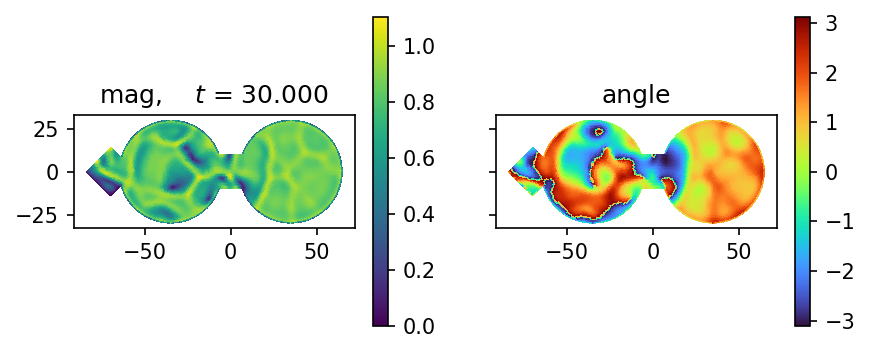

(<Figure size 900x450 with 4 Axes>,
 array([<Axes: title={'center': 'mag,    $t$ = 30.000'}>,
        <Axes: title={'center': 'angle'}>], dtype=object))

In [66]:
#mesh2 = ngsolve.Mesh(geo.GenerateMesh (maxh=maxhval/2))
#xv,yv,triangles = pts_tri(mesh2) # get coordinates and triangles from the mesh

disp(mesh2,gfu,30,xv,yv,triangles)  # worked but is not smooth and boundary does not look great